# Exam notebook 

by Signe Holdgaard

Natural Language Processing, Aarhus University

# Imports

In [2]:
# imports
import pandas as pd
import numpy as np
import csv
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import stanza

import matplotlib.pyplot as plt
import scipy
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.feature_extraction.text import CountVectorizer 


# Data 

In [3]:
# data 
# load data
dtf = pd.read_csv('/Users/signeholdgaard/OneDrive - Aarhus universitet/Master/7 semester/NLP/AUnlp2020/train.csv', sep = ';')

# rename column
dtf = dtf.rename(columns={"sensitivity":"Y"})

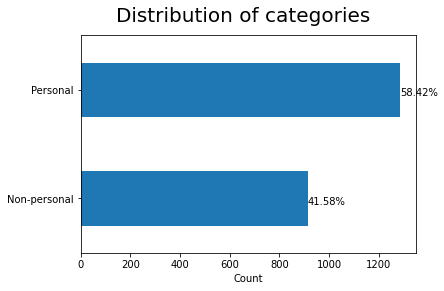

In [4]:
# plot distribution of classification
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []

for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')

positions = (0, 1)
labels = ("Non-personal", "Personal")

plt.suptitle("Distribution of categories", fontsize=20)
plt.xlabel('Count')
plt.yticks(positions, labels)
plt.ylabel('')
plt.show()

# Preprocessing

In [5]:
### Preprocessing
# remove na's in content column 
dtf.dropna(subset=['content'], inplace=True)

# prepare dataframe
content = dtf["content"].tolist()

In [6]:
# stopwords removal 
from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stopwords:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

xcontent = remove_stopwords(content)

In [7]:
# replace phone numbers with tag 

import re

e_l = xcontent

all_lines = []
for line in e_l:
    all_lines.append(re.sub('(\d?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}))', r'PHONE', line))

# add results to dataframe 
dtf['phone'] = all_lines

In [8]:
# replace all named entities with labels e.g. 'person', 'org' etc.

import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

result = []

s = dtf['phone']
for i in s:
    doc = nlp(i)
    newString = i
    for e in reversed(doc.ents): 
        start = e.start_char
        end = start + len(e.text)
        newString = newString[:start] + e.label_ + newString[end:]
    result.append(newString)


In [9]:
# add results to dataframe 
dtf['ner_content'] = result

In [10]:
# Replace all email adresses with 'email' 

e = dtf['ner_content']

new_lines = []
for line in e:
    new_lines.append(re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', r'EMAIL', line))

In [11]:
# add results to dataframe 
dtf['ner_full'] = new_lines

# Naive Bayes Classifier

In [12]:
# Multinomial NB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn import preprocessing




In [13]:
# split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(dtf['ner_full'],dtf["Y"], train_size=0.70,test_size=0.30,random_state = 44)

In [14]:
# Convert the content of the email into count vectors on the X training and test set 
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [15]:
# create Multinomial Naive Bayes model
model = MultinomialNB()

# fit model
classifier = model.fit(X_train_cv, y_train)


In [16]:
# Scores on training and test set 
print('Training set score: {:.4f}'.format(model.score(X_train_cv, y_train)))

print('Test set score: {:.4f}'.format(model.score(X_test_cv, y_test)))

Training set score: 0.8778
Test set score: 0.7909


In [17]:
# predictions
expected = y_test
predicted = model.predict(X_test_cv)

# accuracy and stats for the test data
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       265
           1       0.79      0.89      0.84       395

    accuracy                           0.79       660
   macro avg       0.79      0.77      0.77       660
weighted avg       0.79      0.79      0.79       660

[[170  95]
 [ 43 352]]


In [18]:
# accuracy
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

Accuracy: 0.7909090909090909


[[170  95]
 [ 43 352]]


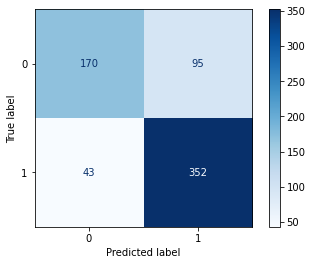

In [19]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(classifier, X_test_cv, y_test,
                                 cmap=plt.cm.Blues)

print(disp.confusion_matrix)

plt.show()

In [20]:
# extract true positives, true negatives, false positives and false negatives

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted)

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]



In [21]:
# calculation of precision
precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))

Precision : 0.6415


In [22]:
# calculation of recall
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.7981


In [23]:
# cross-validation scores 

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_cv, y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.76623377 0.84415584 0.80519481 0.7987013  0.78571429 0.82467532
 0.79220779 0.76623377 0.74509804 0.78431373]


In [24]:
# average cross-validation score

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

# expected performance level of 79%

Average cross-validation score: 0.7913


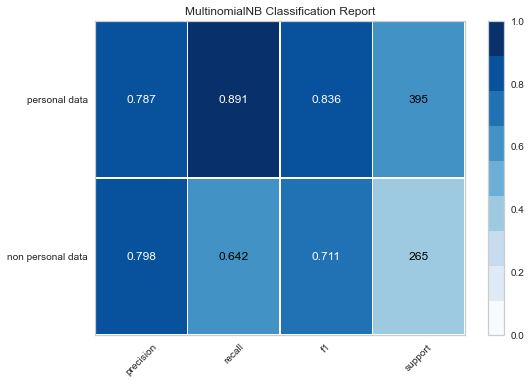

<AxesSubplot:title={'center':'MultinomialNB Classification Report'}>

In [25]:
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

# Visualize classification report 
model = MultinomialNB()
classes = ["non personal data", "personal data"]
visualizer = ClassificationReport(model, classes=classes, support=True, cmap='Blues')

visualizer.fit(X_train_cv, y_train)  # Fit the visualizer and the model
visualizer.score(X_test_cv, y_test)  # Evaluate the model on the test data
visualizer.show()            # show the data


In [26]:
# Investigate the incorrect labels

testing_predictions = []
for i in range(len(X_test)):
    if predicted[i] == 1:
        testing_predictions.append('Personal')
    else:
        testing_predictions.append('Non-personal')

check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'content':list(X_test)})
check_df.replace(to_replace=0, value='Non-personal', inplace=True)
check_df.replace(to_replace=1, value='Personal', inplace=True)

print(check_df.loc[2, 'content']) #predicted personal but non-personal
print(check_df.loc[21, 'content']) #predicted personal and is personal
print(check_df.loc[119, 'content']) #predicted non-personal but personal
print(check_df.loc[156, 'content']) #predicted non personal and is nonpersonal

PERSON, give details email plan prior meeting? need provide besides headcount? Otherwise TIME DATE would fine ORG
Thanks agreeing help. Please call PERSON get things going. PERSON
PERSON, PERSON problems accessing ORG. please make sure active password. Thank you, PERSON
Mark, Thank offer, ride year. Good luck. Phillip


# Test of other classification models

This section serves as an investigation of alternative classification models to the Multinomial Naive Bayes used above. 

This is done to see if other models could potentially obtain better performance metrics. 

## Linear Support Vector Machine

In [28]:

# imports
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# pipeline for lsvm classifier w. countvector, tfidf and stochastic gradient descent (SGD) learning using hinge gives a linear svm
sgd = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                ])

# fit pipeline on training data 
sgd.fit(X_train, y_train)

# predict test data
y_pred = sgd.predict(X_test)

# classification report for performance on test data
print(classification_report(y_test, y_pred,target_names=["non personal data", "personal data"]))

                   precision    recall  f1-score   support

non personal data       0.82      0.85      0.83       265
    personal data       0.90      0.87      0.88       395

         accuracy                           0.86       660
        macro avg       0.86      0.86      0.86       660
     weighted avg       0.86      0.86      0.86       660



## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

# pipeline for logisitic regression classifier with count vector and tfidf 
logreg = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

# fit pipeline on training data
logreg.fit(X_train, y_train)

# predictions on test data
y_pred = logreg.predict(X_test)

# classification report for performance on test data
print(classification_report(y_test, y_pred,target_names=["non personal data", "personal data"]))

                   precision    recall  f1-score   support

non personal data       0.80      0.81      0.80       265
    personal data       0.87      0.86      0.87       395

         accuracy                           0.84       660
        macro avg       0.83      0.84      0.83       660
     weighted avg       0.84      0.84      0.84       660

